In [74]:
# imports
import os
import string
import glob
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image, ImageFile
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM,
    Embedding,
    TimeDistributed,
    Dense,
    RepeatVector,
    Activation,
    Flatten,
    Reshape,
    concatenate,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import keyboard

In [2]:
START = "startseq"
STOP = "endseq"
EPOCHS = 6
USE_INCEPTION = True

In [3]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [4]:
root_captioning = "../Captioning"


# ### Clean/Build Dataset From Flickr8k
#
# We must pull in the Flickr dataset captions and clean them of extra whitespace, punctuation, and other distractions.

null_punct = str.maketrans("", "", string.punctuation)
lookup = dict()

with open(
    os.path.join(root_captioning, "Flickr8k_text", "Flickr8k.token.txt"), "r"
) as fp:

    max_length = 0
    for line in fp.read().split("\n"):
        tok = line.split()
        if len(line) >= 2:
            id = tok[0].split(".")[0]
            desc = tok[1:]

            # Cleanup description
            desc = [word.lower() for word in desc]
            desc = [w.translate(null_punct) for w in desc]
            desc = [word for word in desc if len(word) > 1]
            desc = [word for word in desc if word.isalpha()]
            max_length = max(max_length, len(desc))

            if id not in lookup:
                lookup[id] = list()
            lookup[id].append(" ".join(desc))

lex = set()
for key in lookup:
    [lex.update(d.split()) for d in lookup[key]]

In [5]:
print(len(lookup))  # How many unique words
print(len(lex))  # The dictionary
print(max_length)  # Maximum length of a caption (in words)

8092
8763
32


In [6]:
# Load the Glove embeddings.
# Warning, running this too soon on GDrive can sometimes not work.
# Just rerun if len(img) = 0
img = glob.glob(os.path.join(root_captioning, "Flicker8k_Dataset", "*.jpg"))


# Display the count of how many Glove embeddings we have.
len(img)

2627

In [7]:
# Read all image names and use the predefined train/test sets.
train_images_path = os.path.join(
    root_captioning, "Flickr8k_text", "Flickr_8k.trainImages.txt"
)
train_images = set(open(train_images_path, "r").read().strip().split("\n"))
test_images_path = os.path.join(
    root_captioning, "Flickr8k_text", "Flickr_8k.testImages.txt"
)
test_images = set(open(test_images_path, "r").read().strip().split("\n"))

train_img = []
test_img = []

In [8]:
for i in img:
    f = os.path.split(i)[-1]
    if f in train_images:
        train_img.append(f)
    elif f in test_images:
        test_img.append(f)

In [9]:
# Display the size of the train and test sets.
print(len(train_images))
print(len(test_images))

6000
1000


In [10]:
# Build the sequences.  We include a **start** and **stop** token at the beginning/end.  We will later use the **start** token to begin the process of generating a caption.  Encountering the **stop** token in the generated text will let us know we are done.
train_descriptions = {k: v for k, v in lookup.items() if f"{k}.jpg" in train_images}
for n, v in train_descriptions.items():
    for d in range(len(v)):
        v[d] = f"{START} {v[d]} {STOP}"

In [11]:
# See how many discriptions were extracted.
len(train_descriptions)

6000

In [12]:
# ### Choosing a Computer Vision Neural Network to Transfer
#
# There are two neural networks that are accessed via transfer learning.  In this example, I use Glove for the text embedding and InceptionV3 to extract features from the images.  Both of these transfers serve to extract features from the raw text and the images.  Without this prior knowldge transferred in, this example would take consideraby more training.
#
# I made it so you can interchange the neural network used for the images.  By setting the values WIDTH, HEIGHT, and OUTPUT_DIM you can interchange images.  One characteristic that you are seeking for the image neural network is that it does not have too many outputs (once you strip the 1000-class imagenet classifier, as is common in transfer learning).  InceptionV3 has 2,048 features below the classifier and MobileNet has over 50K.  If the additional dimensions truely capture aspects of the images, then they are worthwhile.  However, having 50K features increases the processing needed and the complexity of the neural network we are constructing.

In [13]:
encode_model = InceptionV3(weights="imagenet")
encode_model = Model(encode_model.input, encode_model.layers[-2].output)
WIDTH = 299
HEIGHT = 299
OUTPUT_DIM = 2048
preprocess_input = tensorflow.keras.applications.inception_v3.preprocess_input

In [14]:
# The summary for the chosen image neural network to be transfered is displayed.
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [15]:
# ### Creating the Training Set
#
# We we need to encode the images to create the training set.  Later we will encode new images to present them for captioning.
def encodeImage(img):
    # Resize all images to a standard size (specified bythe image encoding network)
    img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
    # Convert a PIL image to a numpy array
    x = tensorflow.keras.preprocessing.image.img_to_array(img)
    # Expand to 2D array
    x = np.expand_dims(x, axis=0)
    # Perform any preprocessing needed by InceptionV3 or others
    x = preprocess_input(x)
    # Call InceptionV3 (or other) to extract the smaller feature set for the image.
    x = encode_model.predict(x)  # Get the encoding vector for the image
    # Shape to correct form to be accepted by LSTM captioning network.
    x = np.reshape(x, OUTPUT_DIM)
    return x

In [16]:
def encodeImageArray(img):
    img = tensorflow.keras.preprocessing.image.array_to_img(img)
    # Resize all images to a standard size (specified bythe image encoding network)
    img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
    # Convert a PIL image to a numpy array
    x = tensorflow.keras.preprocessing.image.img_to_array(img)
    # Expand to 2D array
    x = np.expand_dims(x, axis=0)
    # Perform any preprocessing needed by InceptionV3 or others
    x = preprocess_input(x)
    # Call InceptionV3 (or other) to extract the smaller feature set for the image.
    x = encode_model.predict(x)  # Get the encoding vector for the image
    # Shape to correct form to be accepted by LSTM captioning network.
    x = np.reshape(x, OUTPUT_DIM)
    return x

In [17]:
# We can how generate the training set.  This will involve looping over every JPG that was provied.  Because this can take awhile to perform we will save it to a pickle file.  This saves the considerable time needed to completly reprocess all of the images.  Because the images are processed differently by different transferred neural networks, the output dimensions are also made part of the file name.  If you changed from InceptionV3 to MobileNet, the number of output dimensions would change, and a new file would be created.
train_path = os.path.join(root_captioning, "data", f"train{OUTPUT_DIM}.pkl")
if not os.path.exists(train_path):
    start = time()
    encoding_train = {}
    for id in tqdm(train_img):
        image_path = os.path.join(root_captioning, "Flicker8k_Dataset", id)
        img = tensorflow.keras.preprocessing.image.load_img(
            image_path, target_size=(HEIGHT, WIDTH)
        )
        encoding_train[id] = encodeImage(img)
    with open(train_path, "wb") as fp:
        pickle.dump(encoding_train, fp)
    print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
    with open(train_path, "rb") as fp:
        encoding_train = pickle.load(fp)

In [18]:
# A similar process must also be performed for the test images.
test_path = os.path.join(root_captioning, "data", f"test{OUTPUT_DIM}.pkl")
if not os.path.exists(test_path):
    start = time()
    encoding_test = {}
    for id in tqdm(test_img):
        image_path = os.path.join(root_captioning, "Flicker8k_Dataset", id)
        img = tensorflow.keras.preprocessing.image.load_img(
            image_path, target_size=(HEIGHT, WIDTH)
        )
        encoding_test[id] = encodeImage(img)
    with open(test_path, "wb") as fp:
        pickle.dump(encoding_test, fp)
    print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
    with open(test_path, "rb") as fp:
        encoding_test = pickle.load(fp)

In [19]:
# Next we separate the captions that will be usef for training.  There are two sides to this training, the images and the captions.

all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [20]:
# Words that do not occur very often can be misleading to neural network training.  It is better to simply remove such words.  Here we remove any words that occur less than 10 times.  We display what the total vocabulary shrunk to.
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(" "):
        word_counts[w] = word_counts.get(w, 0) + 1

In [21]:
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print("preprocessed words %d ==> %d" % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


In [22]:
# Next we build two lookup tables for this vocabulary. One idxtoword convers index numbers to actual words to index values.  The wordtoidx lookup table performs the opposit.

idxtoword = {}
wordtoidx = {}

In [23]:
ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1

vocab_size = len(idxtoword) + 1
vocab_size

1652

In [24]:
# Previously we added a start and stop token to all sentences.  We must account for this in the maximum length of captions.

max_length += 2
print(max_length)

34


In [25]:
def data_generator(descriptions, photos, wordtoidx, max_length, num_photos_per_batch):
    # x1 - Training data for photos
    # x2 - The caption that goes with each photo
    # y - The predicted rest of the caption
    x1, x2, y = [], [], []
    n = 0
    while True:
        for key, desc_list in descriptions.items():
            n += 1
            photo = photos[key + ".jpg"]
            # Each photo has 5 descriptions
            for desc in desc_list:
                # Convert each word into a list of sequences.
                seq = [wordtoidx[word] for word in desc.split(" ") if word in wordtoidx]
                # Generate a training case for every possible sequence and outcome
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    x1.append(photo)
                    x2.append(in_seq)
                    y.append(out_seq)
            if n == num_photos_per_batch:
                yield ([np.array(x1), np.array(x2)], np.array(y))
                x1, x2, y = [], [], []
                n = 0

In [26]:
# ### Loading Glove Embeddings

glove_dir = os.path.join(root_captioning, "glove.6B")
embeddings_index = {}
f = open(os.path.join(glove_dir, "glove.6B.200d.txt"), encoding="utf-8")

In [27]:
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs

400001it [00:14, 27637.93it/s]


In [28]:
f.close()
print(f"Found {len(embeddings_index)} word vectors.")

Found 400001 word vectors.


In [29]:
# ### Building the Neural Network
#
# An embedding matrix is built from Glove.  This will be directly copied to the weight matrix of the neural network.

embedding_dim = 200

In [30]:
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [31]:
for word, i in wordtoidx.items():
    # if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [32]:
# The matrix makes sense.  It is 1652 (the size of the vocabulary) by 200 (the number of features Glove generates for each word).

embedding_matrix.shape

(1652, 200)

In [33]:
inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation="relu")(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation="relu")(decoder1)
outputs = Dense(vocab_size, activation="softmax")(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [34]:
print(embedding_dim)
caption_model.summary()

200
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 200)              330400    ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                        

In [35]:
caption_model.layers[2].set_weights([embedding_matrix])
caption_model.layers[2].trainable = False
caption_model.compile(loss="categorical_crossentropy", optimizer="adam")

In [36]:
start = 0
model_path = os.path.join(root_captioning, "data", f"caption-model.hdf5")
caption_model.load_weights(model_path)

In [37]:
# ### Generating Captions
#
# It is important to understand that a caption is not generated with one single call to the neural network's predict function.  Neural networks output a fixed-length tensor.  To get a variable length output, such as free-form text, requires multiple calls to the neural network.
#
# The neural network accepts two objects (which are mapped to the input neurons).  The first is the photo.  The second is an ever growing caption.  The caption begins with just the starting token.  The neural network's output is the prediction of the next word in the caption.  This continues until an end token is predicted or we reach the maximum length of a caption.  Each time predict a new word is predicted for the caption.  The word that has the highest probability (from the neural network) is chosen.


def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += " " + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = " ".join(final)
    return final

In [38]:
# @staticmethod
def __draw_label(img, text, pos, bg_color):
    font_face = cv2.FONT_HERSHEY_TRIPLEX
    scale = 0.5
    color = (255, 255, 255)
    thickness = cv2.FILLED
    margin = 5

    txt_size = cv2.getTextSize(text, font_face, scale, thickness)

    end_x = pos[0] + txt_size[0][0] + margin
    end_y = pos[1] - txt_size[0][1] - margin

    cv2.rectangle(img, pos, (end_x, end_y), bg_color, thickness)
    cv2.putText(img, text, pos, font_face, scale, color, 2, cv2.LINE_AA)

In [88]:
def show_image(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")  # Hide axis
    plt.show(block=False)

In [89]:
cap = cv2.VideoCapture(
    "test.mp4"
)

In [90]:
if cap.isOpened() == False:
    print("Error opening video stream or file")

1/1 [==============================] - 0s 67ms/step


C:\Users\ayush\AppData\Local\Temp\ipykernel_21096\3372236671.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)


Caption: two dogs are running through the grass
_____________________________________


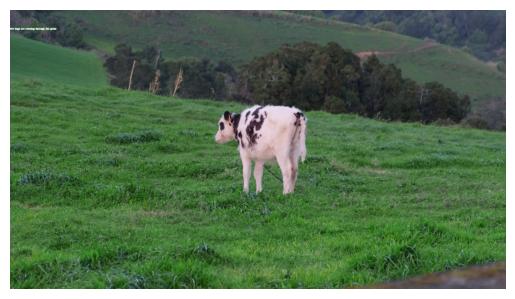

1/1 [==============================] - 0s 64ms/step
Caption: two dogs are running through the grass
_____________________________________


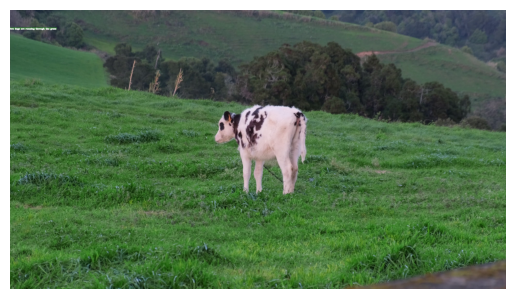

1/1 [==============================] - 0s 85ms/step
Caption: two dogs are running through the grass
_____________________________________


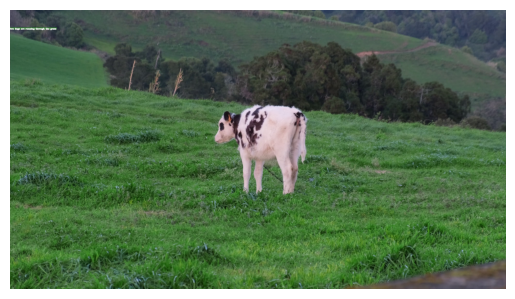

1/1 [==============================] - 0s 67ms/step
Caption: two dogs are running through the grass
_____________________________________


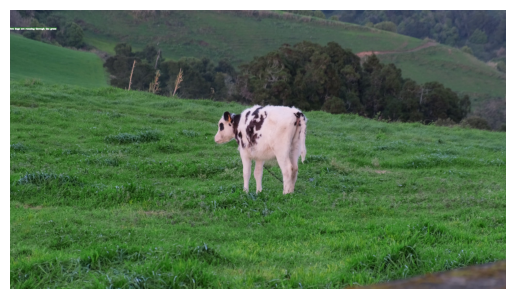

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [91]:
while cap.isOpened():
    ret, frame = cap.read()
    framenc = encodeImageArray(frame).reshape((1, OUTPUT_DIM))
    capstr = generateCaption(framenc)
    print("Caption:", capstr)
    print("_____________________________________")
    __draw_label(frame, capstr, (0, 150), (50, 125, 50))
    show_image(frame)

    if keyboard.is_pressed("q"):
        break
    # Clear the current figure to avoid overlap
    plt.clf()

In [111]:
cap = cv2.VideoCapture(0)

# cap.set(3,640)
# cap.set(4,480)

if cap.isOpened() == False:
    print("Error opening video stream or file")


while cap.isOpened():
    ret, frame = cap.read()
    framenc = encodeImageArray(frame).reshape((1, OUTPUT_DIM))
    capstr = generateCaption(framenc)
    print("Caption:", capstr)
    print("_____________________________________")
    __draw_label(frame, capstr, (0, 150), (50, 125, 50))
    cv2.imshow("Frame", frame)

    if cv2.waitKey(25) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 70ms/step


C:\Users\ayush\AppData\Local\Temp\ipykernel_21096\3372236671.py:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)


Caption: man in black shirt and tie is holding cup
_____________________________________


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [112]:
cap.release()
plt.close()
cv2.destroyAllWindows()

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1266: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
